In [1]:
from kuramoto.nmf import *
from kuramoto.SDL_BCD import SDL_BCD

In [2]:
NWS = nx.newman_watts_strogatz_graph(20000, 1000, 0.67, seed=42)
new_nodes = {e: n for n, e in enumerate(NWS.nodes, start=1)}
new_edges = [(new_nodes[e1], new_nodes[e2]) for e1, e2 in NWS.edges]
edgelist = []
for i in range(len(new_edges)):
    temp = [str(new_edges[i][0]), str(new_edges[i][1])]
    edgelist.append(temp)
G = nn.NNetwork()
G.add_edges(edgelist)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20000
num edges in G 33404370


num of subgraphs induced on k-paths: 1600
X.shape (2500, 1600)


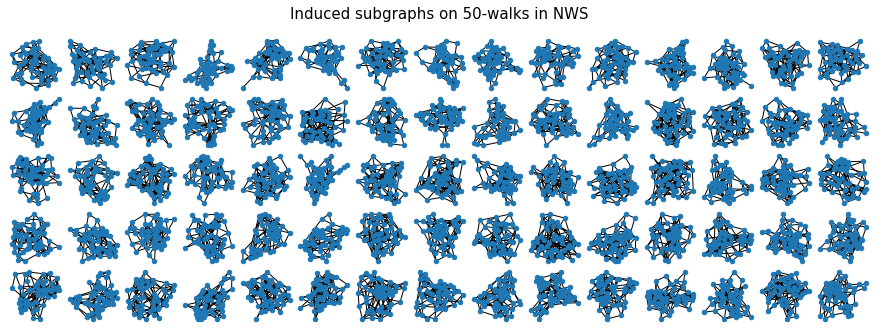

In [3]:
sampling_alg = 'pivot'

ntwk = 'NWS' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

X, embs = G.get_patches(k=k, sample_size=1600, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 1600


In [35]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 0.5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,False
1596,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1598,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True


In [36]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.490625


In [37]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [38]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  3%|█▏                                         | 7/250 [00:00<00:03, 63.19it/s]

iteration 0, reconstruction error 264795.012099
iteration 10, reconstruction error 174753.125300


 11%|████▋                                     | 28/250 [00:00<00:03, 65.52it/s]

iteration 20, reconstruction error 173760.434112
iteration 30, reconstruction error 169190.838216


 20%|████████▍                                 | 50/250 [00:00<00:02, 67.88it/s]

iteration 40, reconstruction error 161200.544818
iteration 50, reconstruction error 158377.491561


 28%|███████████▉                              | 71/250 [00:01<00:02, 65.42it/s]

iteration 60, reconstruction error 157288.114280
iteration 70, reconstruction error 156730.012898


 37%|███████████████▍                          | 92/250 [00:01<00:02, 64.83it/s]

iteration 80, reconstruction error 156401.960560
iteration 90, reconstruction error 156188.452301


 46%|██████████████████▋                      | 114/250 [00:01<00:02, 65.98it/s]

iteration 100, reconstruction error 156034.269072
iteration 110, reconstruction error 155913.220484


 51%|████████████████████▉                    | 128/250 [00:01<00:01, 66.36it/s]

iteration 120, reconstruction error 155813.525634
iteration 130, reconstruction error 155728.422519


 60%|████████████████████████▊                | 151/250 [00:02<00:01, 68.84it/s]

iteration 140, reconstruction error 155653.251853
iteration 150, reconstruction error 155584.889543


 69%|████████████████████████████▏            | 172/250 [00:02<00:01, 66.51it/s]

iteration 160, reconstruction error 155521.755631
iteration 170, reconstruction error 155462.474502


 74%|██████████████████████████████▌          | 186/250 [00:02<00:01, 59.00it/s]

iteration 180, reconstruction error 155406.467846
iteration 190, reconstruction error 155353.356709


 84%|██████████████████████████████████▎      | 209/250 [00:03<00:00, 64.96it/s]

iteration 200, reconstruction error 155303.289475
iteration 210, reconstruction error 155256.387516


 92%|█████████████████████████████████████▋   | 230/250 [00:03<00:00, 64.29it/s]

iteration 220, reconstruction error 155212.977695
iteration 230, reconstruction error 155172.967510


100%|█████████████████████████████████████████| 250/250 [00:03<00:00, 65.66it/s]


iteration 240, reconstruction error 155136.242530


###########################
Shape of W_true: (2500, 9)
###########################




  0%|                                                   | 0/250 [00:00<?, ?it/s]

iteration 0, reconstruction error 269640.945620


  5%|██▏                                       | 13/250 [00:00<00:03, 63.26it/s]

iteration 10, reconstruction error 177151.944547


  8%|███▎                                      | 20/250 [00:00<00:03, 63.57it/s]

iteration 20, reconstruction error 176340.828717


 14%|█████▋                                    | 34/250 [00:00<00:03, 62.95it/s]

iteration 30, reconstruction error 172687.488137


 16%|██████▉                                   | 41/250 [00:00<00:03, 63.14it/s]

iteration 40, reconstruction error 164445.638468


 20%|████████▏                                 | 49/250 [00:00<00:03, 64.58it/s]

iteration 50, reconstruction error 161035.832446


 25%|██████████▌                               | 63/250 [00:00<00:02, 63.86it/s]

iteration 60, reconstruction error 159899.565897


 28%|███████████▊                              | 70/250 [00:01<00:02, 65.13it/s]

iteration 70, reconstruction error 159267.838981


 34%|██████████████                            | 84/250 [00:01<00:02, 64.79it/s]

iteration 80, reconstruction error 158870.796029


 36%|███████████████▎                          | 91/250 [00:01<00:02, 64.90it/s]

iteration 90, reconstruction error 158596.331237


 45%|██████████████████▎                      | 112/250 [00:01<00:02, 60.89it/s]

iteration 100, reconstruction error 158389.746714
iteration 110, reconstruction error 158224.075811


 53%|█████████████████████▊                   | 133/250 [00:02<00:01, 61.81it/s]

iteration 120, reconstruction error 158086.190492
iteration 130, reconstruction error 157968.161441


 62%|█████████████████████████▎               | 154/250 [00:02<00:01, 63.71it/s]

iteration 140, reconstruction error 157865.478427
iteration 150, reconstruction error 157775.816027


 67%|███████████████████████████▌             | 168/250 [00:02<00:01, 65.74it/s]

iteration 160, reconstruction error 157696.771912
iteration 170, reconstruction error 157626.905633


 76%|██████████████████████████████▉          | 189/250 [00:02<00:00, 65.04it/s]

iteration 180, reconstruction error 157565.164646
iteration 190, reconstruction error 157510.878154


 84%|██████████████████████████████████▍      | 210/250 [00:03<00:00, 65.44it/s]

iteration 200, reconstruction error 157463.519166
iteration 210, reconstruction error 157422.752605


 92%|█████████████████████████████████████▉   | 231/250 [00:03<00:00, 65.18it/s]

iteration 220, reconstruction error 157387.709539
iteration 230, reconstruction error 157357.846452


100%|█████████████████████████████████████████| 250/250 [00:03<00:00, 63.47it/s]

iteration 240, reconstruction error 157332.463267


###########################
Shape of W_false: (2500, 9)
###########################




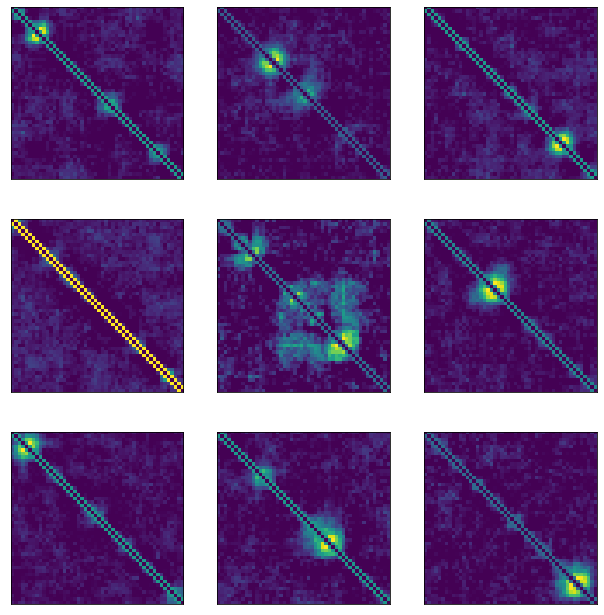

In [39]:
display_dictionary(W = W_true,
                   figsize = [10,10])

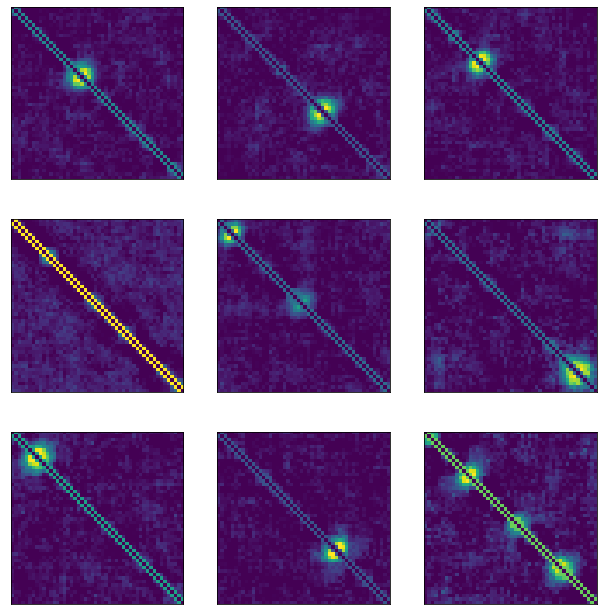

In [40]:
display_dictionary(W = W_false,
                   figsize = [10,10])

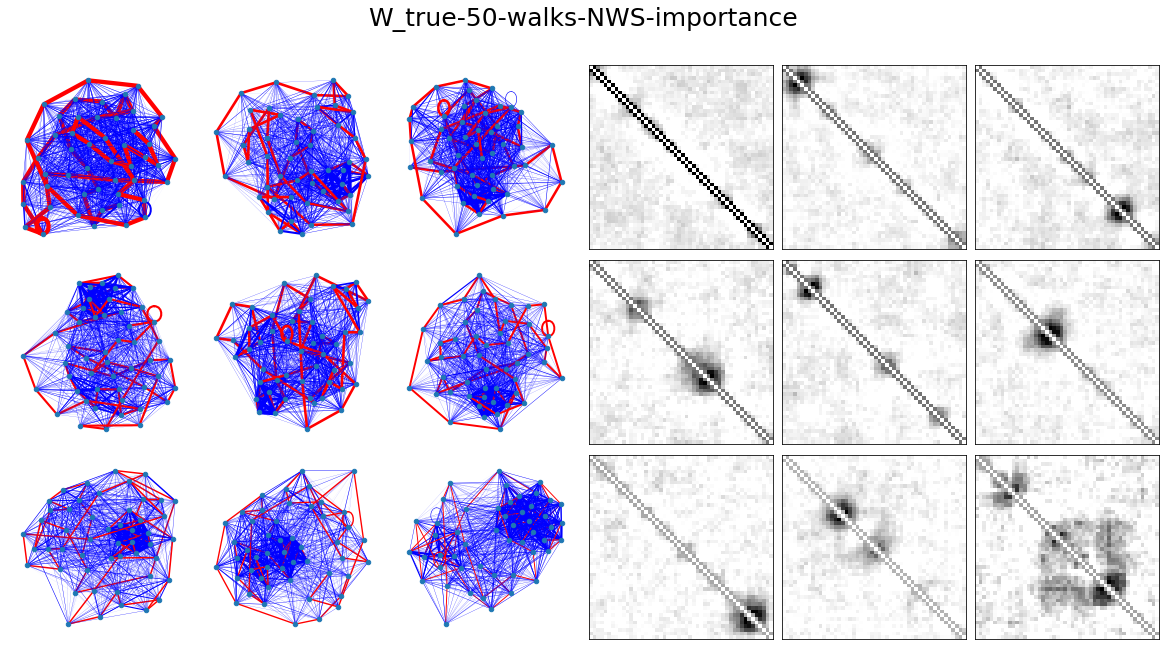

In [41]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

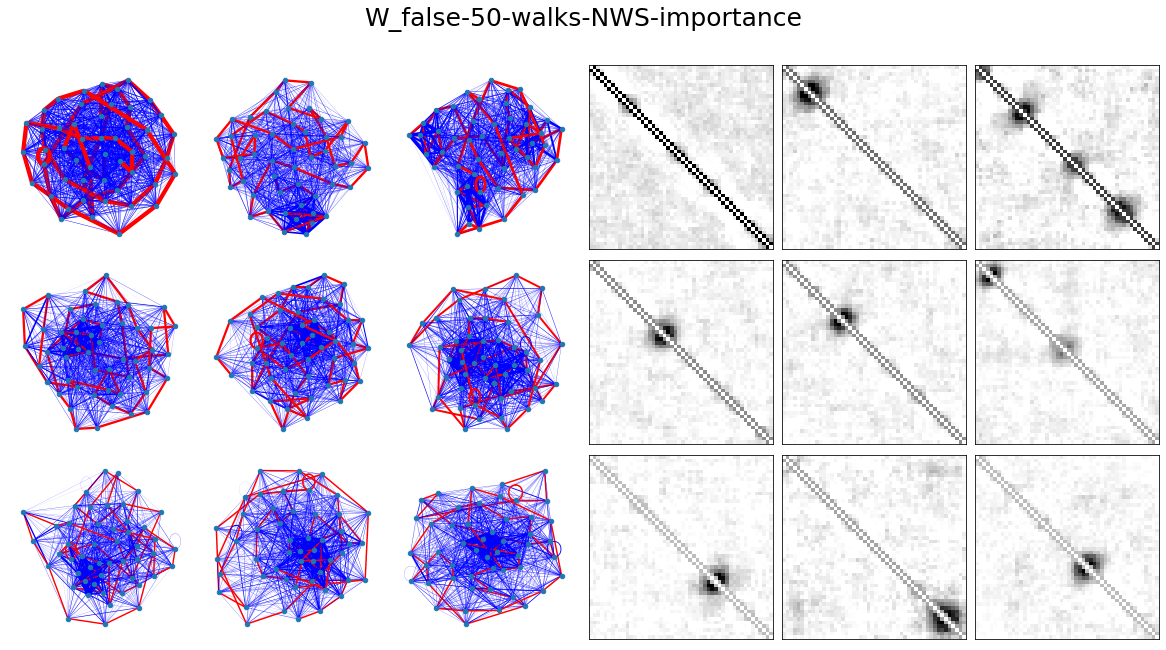

In [42]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [43]:
true_norm = np.linalg.norm(W_true.T, ord=1, axis=1)
false_norm = np.linalg.norm(W_false.T, ord=1, axis=1)

data_arr = np.stack((true_norm, false_norm), axis=0).T
df_boxplot = pd.DataFrame(data_arr, columns = ['Synchronizing','Non-Synchronizing'])
df_boxplot

,Synchronizing,Non-Synchronizing
0,8.287973,7.509307
1,7.202062,6.937888
2,8.625000,7.554022
3,10.675604,10.861701
4,7.874960,7.865972
5,7.193980,7.140658
6,8.047420,7.320778
7,7.921587,6.281947
8,6.562338,8.924399


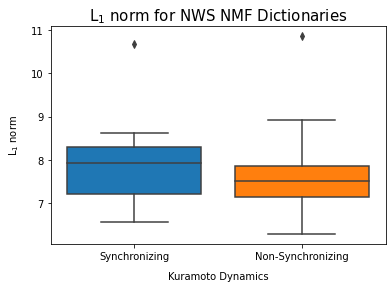

In [45]:
ax = sns.boxplot(data=df_boxplot, saturation=1)
ax.axes.set_title("L$_1$ norm for NWS NMF Dictionaries", fontsize=15)
plt.xlabel("Kuramoto Dynamics", labelpad=10)
plt.ylabel("L$_1$ norm", labelpad=10);

In [46]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

rus = RandomUnderSampler(random_state=42)
X_res, Y_res = rus.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, 
                                                    test_size = 0.2,
                                                    stratify = Y_res)

Y_test = Y_test.T.reshape(-1,1)
Y_train = Y_train.T.reshape(-1,1)

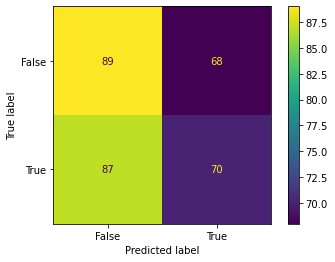

Precision: 0.507
Recall: 0.446
F1: 0.475
Accuracy: 0.506


In [47]:
clf = rf(max_depth=5, max_features="log2").fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
model_metrics(clf, Y_test, Y_pred)

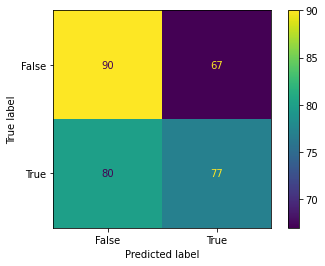

Precision: 0.535
Recall: 0.490
F1: 0.512
Accuracy: 0.532


In [48]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.1, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
model_metrics(clf, Y_test, Y_pred)

In [49]:
# SDL_BCD_feature
data_scale=10
results_dict_list = []
iteration1 = 50
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new = SDL_BCD_class.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.614832    0.38408927 -0.49842679  0.66793019 -0.8187887   0.06330479
  -0.70772384 -0.19159845 -0.94925981 -0.82671744]]


  2%|▉                                           | 1/50 [00:00<00:05,  9.72it/s]

--- Training --- [threshold, AUC] =  [0.577, 0.49]
--- Iteration 0: Training loss --- [Data, Label, Total] = [412.311921.3, 885.491928.3, 885.491928.3]


 20%|████████▌                                  | 10/50 [00:00<00:01, 23.19it/s]


--- Training --- [threshold, AUC] =  [0.998, 0.532]
--- Iteration 10: Training loss --- [Data, Label, Total] = [602.821457.3, 3767.955412.3, 3767.955412.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.33247745  0.24419785  0.039501    0.3346854   0.66984288  0.74244948
  -0.82612499  0.38845242  0.92949401 -0.98689864]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.507, 0.526]
--- Iteration 0: Training loss --- [Data, Label, Total] = [433.845326.3, 870.695616.3, 870.695616.3]


 20%|████████▌                                  | 10/50 [00:00<00:01, 29.41it/s]


--- Training --- [threshold, AUC] =  [0.876, 0.604]
--- Iteration 10: Training loss --- [Data, Label, Total] = [655.637651.3, 1395.281497.3, 1395.281497.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.24447835 -0.24525584  0.62020167 -0.33153527  0.75231333 -0.32959853
   0.58586087 -0.43010446  0.18671964 -0.06830367]]


 18%|███████▉                                    | 9/50 [00:00<00:00, 44.86it/s]

--- Training --- [threshold, AUC] =  [0.373, 0.526]
--- Iteration 0: Training loss --- [Data, Label, Total] = [424.085172.3, 912.632072.3, 955.040589.3]


 20%|████████▌                                  | 10/50 [00:00<00:01, 34.83it/s]


--- Training --- [threshold, AUC] =  [0.011, 0.558]
--- Iteration 10: Training loss --- [Data, Label, Total] = [603.588392.3, 2816.944343.3, 2877.303183.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.23942387  0.00294313  0.13212933 -0.31603526 -0.69760964  0.54716237
  -0.17768038 -0.69178231 -0.0939776  -0.08802291]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.532, 0.475]
--- Iteration 0: Training loss --- [Data, Label, Total] = [426.742915.3, 873.216185.3, 915.890477.3]


 20%|████████▌                                  | 10/50 [00:00<00:01, 38.83it/s]

--- Training --- [threshold, AUC] =  [0.796, 0.586]
--- Iteration 10: Training loss --- [Data, Label, Total] = [594.473013.3, 1141.885680.3, 1201.332982.3]
Early stopping: training loss increased


!!! pred_type naive
initial loading beta [[-0.10522783 -0.87652302 -0.0560513   0.84272422 -0.55017977 -0.64895381
  -0.79687222 -0.21417535  0.67518374 -0.3669681 ]]


 20%|████████▌                                  | 10/50 [00:00<00:00, 49.38it/s]

--- Training --- [threshold, AUC] =  [0.459, 0.526]
--- Iteration 0: Training loss --- [Data, Label, Total] = [415.254116.3, 874.732930.3, 1289.987046.3]
--- Training --- [threshold, AUC] =  [0.373, 0.592]
--- Iteration 10: Training loss --- [Data, Label, Total] = [366.564337.3, 912.535468.3, 1279.099805.3]


 56%|████████████████████████                   | 28/50 [00:00<00:00, 50.45it/s]

--- Training --- [threshold, AUC] =  [0.335, 0.623]
--- Iteration 20: Training loss --- [Data, Label, Total] = [213.624321.3, 942.951345.3, 1156.575666.3]


 80%|██████████████████████████████████▍        | 40/50 [00:00<00:00, 49.71it/s]

--- Training --- [threshold, AUC] =  [0.328, 0.676]
--- Iteration 30: Training loss --- [Data, Label, Total] = [121.324862.3, 949.779350.3, 1071.104212.3]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 47.35it/s]

--- Training --- [threshold, AUC] =  [0.325, 0.759]
--- Iteration 40: Training loss --- [Data, Label, Total] = [72.083131.3, 952.936418.3, 1025.019549.3]
!!! pred_type naive


initial loading beta [[-0.03419051  0.01172972  0.38647619  0.43703196  0.77657165 -0.10555441
   0.46212002  0.60120122 -0.33848033  0.90226774]]


  8%|███▌                                        | 4/50 [00:00<00:01, 39.18it/s]

--- Training --- [threshold, AUC] =  [0.477, 0.526]
--- Iteration 0: Training loss --- [Data, Label, Total] = [408.825097.3, 871.895753.3, 1280.720850.3]


 22%|█████████▍                                 | 11/50 [00:00<00:00, 43.92it/s]

--- Training --- [threshold, AUC] =  [0.464, 0.583]
--- Iteration 10: Training loss --- [Data, Label, Total] = [395.195841.3, 873.671792.3, 1268.867634.3]


 62%|██████████████████████████▋                | 31/50 [00:00<00:00, 49.18it/s]

--- Training --- [threshold, AUC] =  [0.604, 0.587]
--- Iteration 20: Training loss --- [Data, Label, Total] = [243.910850.3, 898.124327.3, 1142.035177.3]
--- Training --- [threshold, AUC] =  [0.695, 0.6]
--- Iteration 30: Training loss --- [Data, Label, Total] = [175.582444.3, 974.506203.3, 1150.088647.3]


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 49.49it/s]

--- Training --- [threshold, AUC] =  [0.752, 0.617]
--- Iteration 40: Training loss --- [Data, Label, Total] = [126.701908.3, 1054.936856.3, 1181.638764.3]
!!! pred_type naive


initial loading beta [[-0.95440039  0.47812817  0.08689616  0.42269525  0.53591862 -0.22744152
   0.90135564 -0.17663375  0.09528969 -0.56380716]]


 10%|████▍                                       | 5/50 [00:00<00:00, 48.28it/s]

--- Training --- [threshold, AUC] =  [0.626, 0.474]
--- Iteration 0: Training loss --- [Data, Label, Total] = [343.638989.3, 911.623870.3, 2629.818815.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 40.97it/s]

--- Training --- [threshold, AUC] =  [0.999, 0.521]
--- Iteration 10: Training loss --- [Data, Label, Total] = [187.276286.3, 4230.284979.3, 5166.666408.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[-0.59839962  0.59357608 -0.12813807  0.85647112 -0.17422822  0.20246335
  -0.75684208 -0.60712466 -0.19751139 -0.86107809]]


  8%|███▌                                        | 4/50 [00:00<00:01, 38.57it/s]

--- Training --- [threshold, AUC] =  [0.453, 0.475]
--- Iteration 0: Training loss --- [Data, Label, Total] = [345.346638.3, 876.155956.3, 2602.889145.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 40.73it/s]

--- Training --- [threshold, AUC] =  [0.0, 0.536]
--- Iteration 10: Training loss --- [Data, Label, Total] = [187.482858.3, 5193.879095.3, 6131.293383.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[-0.07721691  0.6509653  -0.37060907 -0.39939234 -0.13434481 -0.54251788
   0.03923861  0.62080255 -0.5491382  -0.00427893]]


  8%|███▌                                        | 4/50 [00:00<00:01, 38.88it/s]

--- Training --- [threshold, AUC] =  [0.487, 0.526]
--- Iteration 0: Training loss --- [Data, Label, Total] = [341.854995.3, 871.033828.3, 4289.583779.3]


 22%|█████████▍                                 | 11/50 [00:00<00:00, 45.37it/s]

--- Training --- [threshold, AUC] =  [0.272, 0.504]
--- Iteration 10: Training loss --- [Data, Label, Total] = [176.592608.3, 1016.624391.3, 2782.550474.3]


 40%|█████████████████▏                         | 20/50 [00:00<00:00, 43.13it/s]


--- Training --- [threshold, AUC] =  [0.041, 0.643]
--- Iteration 20: Training loss --- [Data, Label, Total] = [107.178138.3, 2028.571770.3, 3100.353153.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.51408644 -0.88282897  0.39566584  0.6103072   0.34596017  0.37854581
   0.68315137  0.32134282 -0.66205213 -0.9275188 ]]


  8%|███▌                                        | 4/50 [00:00<00:01, 38.94it/s]

--- Training --- [threshold, AUC] =  [0.631, 0.474]
--- Iteration 0: Training loss --- [Data, Label, Total] = [350.244201.3, 915.451362.3, 4417.893375.3]


 20%|████████▌                                  | 10/50 [00:00<00:01, 38.88it/s]

--- Training --- [threshold, AUC] =  [1.0, 0.547]
--- Iteration 10: Training loss --- [Data, Label, Total] = [161.364758.3, 5661.986770.3, 7275.634347.3]
Early stopping: training loss increased


!!! pred_type naive


In [50]:
W = results_dict_new['loading'][0]
coeff = results_dict_new['loading'][1][0]
H = results_dict_new['code']

In [51]:
coeff

array([-7.87960830e-04,  1.71245779e-02,  2.08582671e-02,  2.08864208e-02,
        1.15078042e-03,  7.11245903e-05, -2.24105264e-04,  3.11133418e-03,
       -1.33057491e-03,  1.25440179e-02])

In [52]:
print('Accuracy: {}'.format(results_dict_new['Accuracy']))

Accuracy: 0.5318471337579618


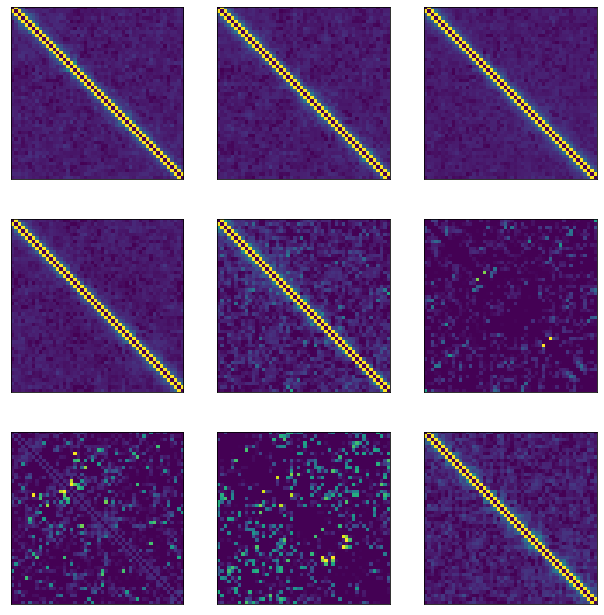

In [53]:
display_dictionary(W = W, figsize=[10,10])

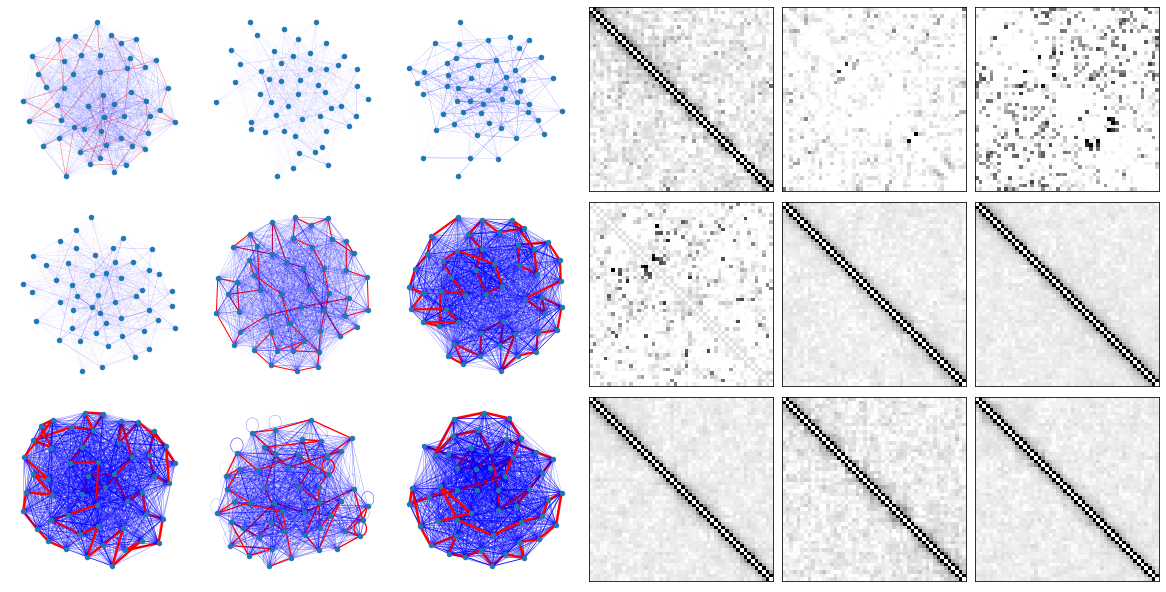

In [54]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T),
                       weight_graph = 50, 
                       fig_size = [20,10], 
                       show_importance = True)

In [55]:
# SDL_BCD_filter
data_scale=1
results_dict_list_filter = []
iteration1 = 50
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter = SDL_BCD_class_filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[-0.99596175 -0.6302031   0.37863909  0.85079294 -0.74390947 -0.48336915
  -0.33480163  0.2972588  -0.98038618 -0.7855104 ]]


  6%|██▋                                         | 3/50 [00:00<00:06,  7.23it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.54]
--- Iteration 0: Training loss --- [Data, Label, Total] = [227.427097.3, 870.588896.3, 870.588896.3]


 26%|███████████▏                               | 13/50 [00:01<00:03,  9.58it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.549]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.640785.3, 870.587030.3, 870.587030.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:03,  9.04it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.62]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.505702.3, 870.553657.3, 870.553657.3]


 66%|████████████████████████████▍              | 33/50 [00:03<00:01, 10.32it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.726]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.582710.3, 870.444827.3, 870.444827.3]


 86%|████████████████████████████████████▉      | 43/50 [00:04<00:00,  9.63it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.743]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.622953.3, 870.425586.3, 870.425586.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.33it/s]


!!! pred_type filter
initial loading beta [[ 0.67896118 -0.23586204 -0.02294535 -0.69955635  0.72220212  0.37067777
   0.10009141 -0.92838097  0.53862992 -0.05643352]]


  6%|██▋                                         | 3/50 [00:00<00:05,  9.35it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.541]
--- Iteration 0: Training loss --- [Data, Label, Total] = [224.017529.3, 870.588985.3, 870.588985.3]


 26%|███████████▏                               | 13/50 [00:01<00:04,  8.29it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.549]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.644104.3, 870.587125.3, 870.587125.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:03,  7.24it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.622]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.510747.3, 870.553024.3, 870.553024.3]


 64%|███████████████████████████▌               | 32/50 [00:03<00:02,  8.33it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.727]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.587599.3, 870.443671.3, 870.443671.3]


 84%|████████████████████████████████████       | 42/50 [00:04<00:00,  8.21it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.743]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.624176.3, 870.425497.3, 870.425497.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.87it/s]


!!! pred_type filter
initial loading beta [[ 0.04067997 -0.34951055  0.35705202 -0.61944067 -0.37726839  0.3144804
   0.68948555 -0.19657267  0.04036814  0.4060827 ]]


  2%|▉                                           | 1/50 [00:00<00:06,  8.01it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.539]
--- Iteration 0: Training loss --- [Data, Label, Total] = [235.501015.3, 870.589224.3, 894.139326.3]


 24%|██████████▎                                | 12/50 [00:01<00:04,  9.30it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.545]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.607170.3, 870.588231.3, 870.748947.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:03,  9.12it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.575]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.222096.3, 870.579983.3, 870.702193.3]


 64%|███████████████████████████▌               | 32/50 [00:03<00:02,  7.85it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.621]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.080685.3, 870.557973.3, 870.666042.3]


 86%|████████████████████████████████████▉      | 43/50 [00:04<00:00,  8.10it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.67]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.052404.3, 870.521344.3, 870.626585.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.91it/s]


!!! pred_type filter
initial loading beta [[ 0.6366131  -0.85973997 -0.74004433  0.47003185 -0.40269065  0.93062823
   0.80454844 -0.76718476  0.70601245  0.66693123]]


  6%|██▋                                         | 3/50 [00:00<00:04, 10.17it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.541]
--- Iteration 0: Training loss --- [Data, Label, Total] = [231.451499.3, 870.588938.3, 893.734087.3]


 22%|█████████▍                                 | 11/50 [00:01<00:03, 10.39it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.546]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.600506.3, 870.588082.3, 870.748132.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:02,  9.39it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.577]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.232603.3, 870.579087.3, 870.702347.3]


 66%|████████████████████████████▍              | 33/50 [00:03<00:01,  9.84it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.628]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.087265.3, 870.554580.3, 870.663307.3]


 86%|████████████████████████████████████▉      | 43/50 [00:04<00:00,  9.46it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.677]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.053741.3, 870.515462.3, 870.620836.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.72it/s]


!!! pred_type filter
initial loading beta [[-0.31324405 -0.87959457 -0.07971333 -0.18628368  0.24386285 -0.25717157
   0.37116734 -0.90469846 -0.88252144 -0.61741474]]


  4%|█▊                                          | 2/50 [00:00<00:05,  8.23it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.541]
--- Iteration 0: Training loss --- [Data, Label, Total] = [300.484408.3, 870.590374.3, 1171.074782.3]


 24%|██████████▎                                | 12/50 [00:01<00:05,  7.51it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.536]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.337123.3, 870.591061.3, 871.928183.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:03,  8.93it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.537]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.078419.3, 870.590931.3, 871.669350.3]


 64%|███████████████████████████▌               | 32/50 [00:03<00:02,  8.77it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.538]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.055527.3, 870.590814.3, 871.646341.3]


 84%|████████████████████████████████████       | 42/50 [00:04<00:00,  8.47it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.539]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.048223.3, 870.590693.3, 871.638917.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.87it/s]


!!! pred_type filter
initial loading beta [[-0.75682439  0.64324003 -0.19011577 -0.66893656  0.26037331  0.53019565
  -0.10233893 -0.89239589  0.03136153  0.17853002]]


  2%|▉                                           | 1/50 [00:00<00:06,  7.43it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.539]
--- Iteration 0: Training loss --- [Data, Label, Total] = [305.749907.3, 870.590528.3, 1176.340435.3]


 24%|██████████▎                                | 12/50 [00:01<00:04,  8.49it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.539]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.426564.3, 870.591216.3, 872.017780.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:02,  9.64it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.54]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.113380.3, 870.591079.3, 871.704459.3]


 64%|███████████████████████████▌               | 32/50 [00:03<00:02,  8.77it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.541]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.072774.3, 870.590949.3, 871.663722.3]


 84%|████████████████████████████████████       | 42/50 [00:04<00:00,  8.86it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.542]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.057648.3, 870.590812.3, 871.648460.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.90it/s]


!!! pred_type filter
initial loading beta [[-0.07710951  0.95205179  0.58137856 -0.38366997  0.71990108  0.46778982
  -0.90799    -0.90305848 -0.69537165  0.24410047]]


  2%|▉                                           | 1/50 [00:00<00:07,  6.13it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.542]
--- Iteration 0: Training loss --- [Data, Label, Total] = [293.300100.3, 870.592154.3, 2337.092653.3]


 26%|███████████▏                               | 13/50 [00:01<00:03,  9.76it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.537]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.187930.3, 870.592180.3, 876.531830.3]


 44%|██████████████████▉                        | 22/50 [00:02<00:02,  9.65it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.536]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.067386.3, 870.592173.3, 875.929103.3]


 64%|███████████████████████████▌               | 32/50 [00:03<00:02,  7.76it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.537]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.062843.3, 870.592162.3, 875.906377.3]


 86%|████████████████████████████████████▉      | 43/50 [00:04<00:00,  9.81it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.537]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.061281.3, 870.592151.3, 875.898555.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.24it/s]


!!! pred_type filter
initial loading beta [[ 0.10262289  0.28440621  0.61637542 -0.98398236  0.35996594  0.06035936
   0.94650878  0.38817195  0.62212303  0.73239835]]


  6%|██▋                                         | 3/50 [00:00<00:04,  9.90it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.545]
--- Iteration 0: Training loss --- [Data, Label, Total] = [291.857098.3, 870.592082.3, 2329.877571.3]


 26%|███████████▏                               | 13/50 [00:01<00:03, 10.32it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.523]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.299311.3, 870.592467.3, 877.089020.3]


 46%|███████████████████▊                       | 23/50 [00:02<00:02, 10.12it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.522]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.079658.3, 870.592472.3, 875.990760.3]


 66%|████████████████████████████▍              | 33/50 [00:03<00:01, 10.44it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.522]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.062145.3, 870.592469.3, 875.903195.3]


 86%|████████████████████████████████████▉      | 43/50 [00:04<00:00, 10.66it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.522]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.056771.3, 870.592465.3, 875.876323.3]


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.46it/s]


!!! pred_type filter
initial loading beta [[-0.18965928  0.66466164 -0.5582946  -0.88007671  0.99950186  0.12944083
   0.41490377  0.56533336 -0.33872828 -0.25693794]]


  2%|▉                                           | 1/50 [00:00<00:07,  6.96it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.546]
--- Iteration 0: Training loss --- [Data, Label, Total] = [243.987510.3, 870.592740.3, 3310.467844.3]


 22%|█████████▍                                 | 11/50 [00:01<00:03,  9.93it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.526]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.692714.3, 870.592795.3, 887.519930.3]


 46%|███████████████████▊                       | 23/50 [00:02<00:02, 10.30it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.527]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.678401.3, 870.592795.3, 887.376803.3]


 66%|████████████████████████████▍              | 33/50 [00:03<00:01, 10.47it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.527]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.677032.3, 870.592794.3, 887.363114.3]


 82%|███████████████████████████████████▎       | 41/50 [00:03<00:00, 10.21it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.527]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.675218.3, 870.592794.3, 887.344977.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.73it/s]


!!! pred_type filter
initial loading beta [[-0.36238511 -0.09068481  0.75367292  0.07320132 -0.41164071 -0.68889559
  -0.30771057 -0.86626077 -0.65388303 -0.0047371 ]]


  2%|▉                                           | 1/50 [00:00<00:06,  7.88it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.52]
--- Iteration 0: Training loss --- [Data, Label, Total] = [238.538019.3, 870.592822.3, 3255.973010.3]


 24%|██████████▎                                | 12/50 [00:01<00:04,  8.42it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.507]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.678106.3, 870.592850.3, 887.373912.3]


 46%|███████████████████▊                       | 23/50 [00:02<00:03,  8.90it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.507]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.677677.3, 870.592850.3, 887.369619.3]


 66%|████████████████████████████▍              | 33/50 [00:03<00:01, 10.46it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.507]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.676931.3, 870.592850.3, 887.362158.3]


 86%|████████████████████████████████████▉      | 43/50 [00:04<00:00, 10.39it/s]

--- Training --- [threshold, AUC] =  [0.5, 0.507]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.675848.3, 870.592850.3, 887.351330.3]


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.84it/s]

!!! pred_type filter


In [56]:
W = results_dict_new_filter['loading'][0]
coeff = results_dict_new_filter['loading'][1][0]
H = results_dict_new_filter['code']

In [57]:
coeff

array([-3.66942721e-06,  3.89773455e-04,  3.28270007e-04,  5.46709502e-04,
        4.25482097e-04,  3.02426404e-03,  5.73514518e-04,  5.34377047e-04,
        4.50613220e-04,  4.30375059e-04])

In [58]:
print('Accuracy: {}'.format(results_dict_new_filter['Accuracy']))

Accuracy: 0.49363057324840764


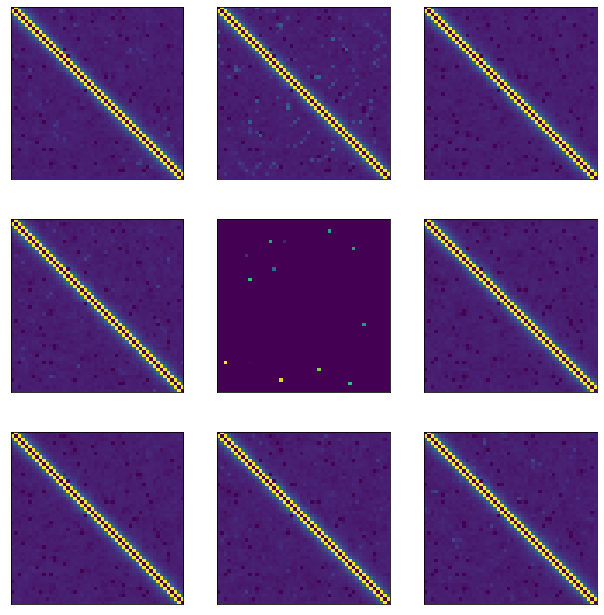

In [59]:
display_dictionary(W = W, figsize=[10,10])

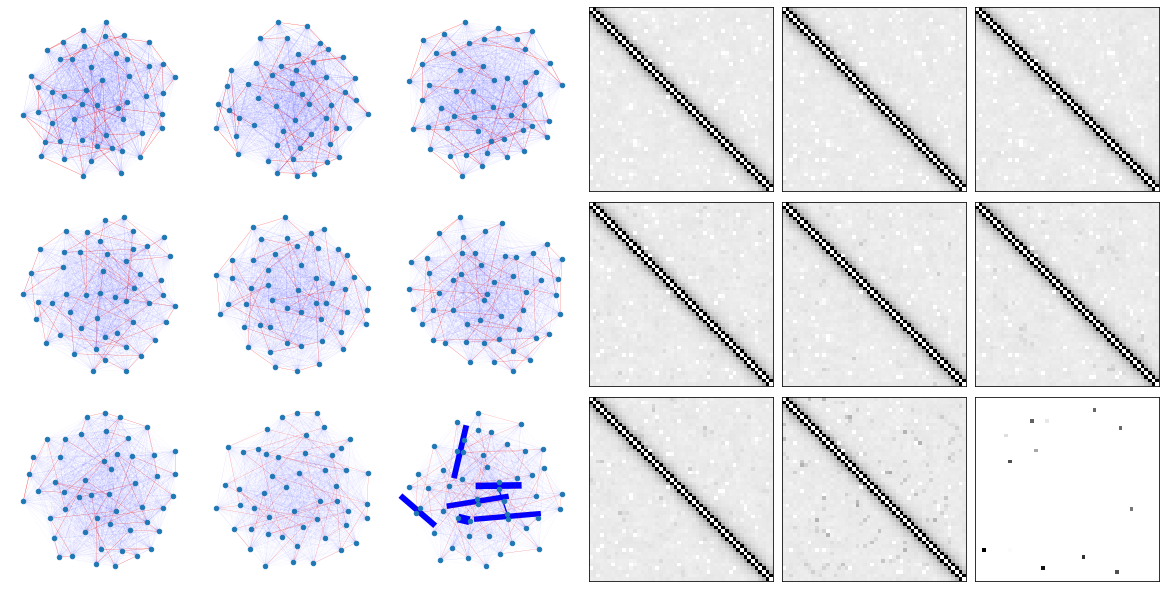

In [60]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       weight_graph = 150, 
                       fig_size = [20,10], 
                       show_importance = True)